# 添加IP特征

In [2]:
from torch.utils.data import DataLoader
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [24]:
from mlp import mlp
import torch
import pandas as pd
# precess training data
train_ft=torch.load('./url/ip/features_train.pt')
url_ft=pd.read_csv('./url/ip/feature_train.csv')
ip_ft=pd.read_csv('./url/ip/ip_train.csv')
ip_ft=ip_ft.iloc[:,5:].to_numpy()
url_ft=url_ft.iloc[:,:7].to_numpy()
url_ft.shape
train_ft=np.concatenate([train_ft.numpy(),url_ft,ip_ft],axis=-1)
train_label=pd.read_csv('./url/ip/train_label.csv')
train_label.value_counts()
train_ft.shape

(3859, 778)

In [25]:
idx=(train_label['label']==2)|(train_label['label']==4)|(train_label['label']==6)|(train_label['label']==8)
train_label.loc[idx,'label']=2
train_label.value_counts()

label
2        3616
9         149
3          37
11         28
10         17
1           5
7           5
5           1
12          1
dtype: int64

In [7]:
def eval_on_test(net,features,labels):
    net.eval()
    global highest_record
    length=len(labels)
    labels=DataLoader(labels,batch_size=64)
    features=DataLoader(features,batch_size=64)
    sum=0
    for feature,label in zip(features,labels):
        output=net(feature)
        predict=torch.argmax(output,dim=-1)
        sum+=(predict==label).sum()
    if sum>highest_record:
        print(f'new record:{sum}')
        highest_record=sum
        torch.save(net.state_dict(),'./classifier_model/best_mlp_ip.pkl')
    print(f"accuracy on test :{sum}/{length}={sum/length}")

In [8]:
def train(lr,batch_size,epoches,features_data,labels_data,test_features,test_labels,over_write=False):
    # load data
    labels=DataLoader(labels_data,batch_size=batch_size)
    features=DataLoader(features_data,batch_size=batch_size)
    # features_data=text_features
    print(features_data.shape)
    # !!!net and solver
    net=mlp(in_features=features_data.shape[-1])

    if os.path.exists('./classifier_model/mlp_ip.pkl') and not over_write:
        state_dict=torch.load('./classifier_model/mlp_ip.pkl')
        net.load_state_dict(state_dict=state_dict)
    criterion=torch.nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(net.parameters(),lr=lr)
    # train
    loss_list=[]
    for e in range(epoches):
        epoch_loss=[]
        for label,feature in zip(labels,features):
            net.train()
            output=net(feature)
            loss=criterion(output,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
        eval_on_test(net,features=test_features,labels=test_labels)
        mean_loss=np.array(epoch_loss).mean()
        loss_list.append(mean_loss)
        print(f'epoch {e+1} loss: {mean_loss}')
    loss_log=pd.DataFrame(loss_list,columns=['loss'])
    if os.path.exists('./log/loss_ip.csv') and not over_write:
        f=pd.read_csv('./log/loss_ip.csv')
        loss_log=pd.concat([f,loss_log],axis=0)
    loss_log.to_csv('./log/loss_ip.csv',index=None)
    torch.save(net.state_dict(),'./classifier_model/mlp_ip.pkl')


In [26]:
test_ft=torch.load('./url/ip/features_test.pt')
test_url_ft=pd.read_csv('./url/ip/feature_test.csv')
test_ip_ft=pd.read_csv('./url/ip/ip_test.csv')
test_url_ft=test_url_ft.iloc[:,:7].to_numpy()
test_ip_ft=test_ip_ft.iloc[:,5:].to_numpy()
test_ft=np.concatenate([test_ft.numpy(),test_url_ft,test_ip_ft],axis=-1)
test_label=pd.read_csv('./url/ip/test_label.csv')
test_label.value_counts()
test_ft.shape

(868, 778)

In [27]:
idx=(test_label['label']==2)|(test_label['label']==4)|(test_label['label']==6)|(test_label['label']==8)
test_label.loc[idx,'label']=2
print(len(test_label))
# print(1175/1536)
test_label.value_counts()

868


label
2        812
9         40
3          7
1          2
7          2
10         2
12         2
11         1
dtype: int64

In [28]:
highest_record=0

In [38]:
train(lr=5e-6,
      batch_size=32,
      epoches=10,
      features_data=torch.tensor(train_ft,dtype=torch.float32),
      labels_data=train_label['label'],
      test_features=torch.tensor(test_ft,dtype=torch.float32),
      test_labels=test_label['label'],
      over_write=False)

torch.Size([3859, 778])
accuracy on test :861/868=0.9919354915618896
epoch 1 loss: 0.01879811823970113
accuracy on test :861/868=0.9919354915618896
epoch 2 loss: 0.01652438685285098
accuracy on test :861/868=0.9919354915618896
epoch 3 loss: 0.01587820266367322
accuracy on test :861/868=0.9919354915618896
epoch 4 loss: 0.015420131338032661
accuracy on test :861/868=0.9919354915618896
epoch 5 loss: 0.01650776054091032
accuracy on test :861/868=0.9919354915618896
epoch 6 loss: 0.015027419557832931
accuracy on test :861/868=0.9919354915618896
epoch 7 loss: 0.015008684606787141
accuracy on test :861/868=0.9919354915618896
epoch 8 loss: 0.01559399669166257
accuracy on test :861/868=0.9919354915618896
epoch 9 loss: 0.015288566052498755
accuracy on test :861/868=0.9919354915618896
epoch 10 loss: 0.014377231726014971


### 训练LR，把2468分成26、48两组

In [39]:
from sklearn import metrics
import pickle
import joblib

In [49]:
#prepare data
train_ft=torch.load('./url/ip/features_train.pt')
url_ft=pd.read_csv('./url/ip/feature_train.csv')
ip_ft=pd.read_csv('./url/ip/ip_train.csv')
ip_ft=ip_ft.iloc[:,5:].to_numpy()
url_ft=url_ft.iloc[:,:7].to_numpy()
train_ft=np.concatenate([train_ft.numpy(),url_ft,ip_ft],axis=-1)
train_label=pd.read_csv('./url/ip/train_label.csv')
idx=(train_label['label']==2)|(train_label['label']==4)|(train_label['label']==6)|(train_label['label']==8)
train_label=train_label[idx]
train_label.value_counts()

label
2        1905
6         903
4         580
8         228
dtype: int64

In [50]:
train_ft=train_ft[idx]
idx1=(train_label['label']==2)|(train_label['label']==6)
train_label[idx1]=2
idx2=(train_label['label']==4)|(train_label['label']==8)
train_label[idx2]=4
train_label.value_counts()

label
2        2808
4         808
dtype: int64

In [51]:
test_ft=torch.load('./url/ip/features_test.pt')
test_url_ft=pd.read_csv('./url/ip/feature_test.csv')
test_ip_ft=pd.read_csv('./url/ip/ip_test.csv')
test_url_ft=test_url_ft.iloc[:,:7].to_numpy()
test_ip_ft=test_ip_ft.iloc[:,5:].to_numpy()
test_ft=np.concatenate([test_ft.numpy(),test_url_ft,test_ip_ft],axis=-1)
test_label=pd.read_csv('./url/ip/test_label.csv')
idx=(test_label['label']==2)|(test_label['label']==4)|(test_label['label']==6)|(test_label['label']==8)
test_ft=test_ft[idx]
test_label=test_label[idx]

In [52]:
idx1=(test_label['label']==2)|(test_label['label']==6)
idx2=(test_label['label']==4)|(test_label['label']==8)
test_label[idx1]=2
test_label[idx2]=4

In [53]:
LR24=LogisticRegression(max_iter=30000)
# LR24=SVC(max_iter=30000,kernel='rbf')
LR24.fit(train_ft,train_label)
LR24.score(test_ft,test_label)

/Users/YZY/opt/anaconda3/envs/pytorch_cpu/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0

In [54]:
pred=LR24.predict(test_ft)
print(metrics.classification_report(test_label,pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00       633
           4       1.00      1.00      1.00       179

    accuracy                           1.00       812
   macro avg       1.00      1.00      1.00       812
weighted avg       1.00      1.00      1.00       812



In [55]:
#save model
joblib.dump(LR24,'./classifier_model/LR24_ip.pkl')

['./classifier_model/LR24_ip.pkl']

### 训练LR，把26分开

In [66]:
train_ft=torch.load('./url/ip/features_train.pt')
url_ft=pd.read_csv('./url/ip/feature_train.csv')
ip_ft=pd.read_csv('./url/ip/ip_train.csv')
ip_ft=ip_ft.iloc[:,5:].to_numpy()
url_ft=url_ft.iloc[:,:7].to_numpy()
train_ft=np.concatenate([train_ft.numpy(),url_ft,ip_ft],axis=-1)
train_label=pd.read_csv('./url/ip/train_label.csv')
idx=(train_label['label']==2)|(train_label['label']==6)
train_label=train_label[idx]
train_ft=train_ft[idx]
train_label.value_counts()

label
2        1905
6         903
dtype: int64

In [67]:
test_ft=torch.load('./url/ip/features_test.pt')
test_url_ft=pd.read_csv('./url/ip/feature_test.csv')
test_ip_ft=pd.read_csv('./url/ip/ip_test.csv')
test_url_ft=test_url_ft.iloc[:,:7].to_numpy()
test_ip_ft=test_ip_ft.iloc[:,5:].to_numpy()
test_ft=np.concatenate([test_ft.numpy(),test_url_ft,test_ip_ft],axis=-1)
test_label=pd.read_csv('./url/ip/test_label.csv')
idx=(test_label['label']==2)|(test_label['label']==6)
test_ft=test_ft[idx]
test_label=test_label[idx]
train_ft.shape

(2808, 778)

In [68]:
LR26=SVC(max_iter=100000,kernel='rbf')
# LR26=LogisticRegression(max_iter=30000)
LR26.fit(train_ft,train_label)
LR26.score(test_ft,test_label)

/Users/YZY/opt/anaconda3/envs/pytorch_cpu/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0

In [87]:
pred=LR26.predict(test_ft)
print(pred)
print(metrics.classification_report(test_label,pred))

[2 2 2 6 2 2 2 2 2 6 6 6 2 2 6 6 2 2 2 2 2 2 2 2 6 6 6 2 2 2 6 2 2 2 2 2 2
 6 2 6 2 2 2 6 6 2 6 2 6 2 6 2 2 6 2 2 2 2 2 2 6 2 2 6 2 6 6 6 6 2 6 2 6 6
 2 6 2 2 2 2 2 2 6 6 2 2 6 2 2 2 2 6 2 2 2 6 2 6 2 6 2 2 2 2 2 2 2 6 2 2 2
 2 2 6 2 6 2 6 2 2 6 2 2 2 6 6 2 2 2 2 2 2 2 2 6 2 2 2 2 2 6 6 6 2 2 6 2 6
 2 2 2 6 6 6 2 2 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 6 2 6 2 2 2 6 2 2 6 6 2
 2 2 2 6 2 2 6 6 6 2 2 2 2 2 2 6 6 2 2 2 2 2 2 6 6 6 2 2 2 2 2 2 2 6 2 2 2
 6 2 6 2 2 2 2 2 6 6 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 6 2 6 6 2 6 6 2 2 6 2
 2 2 2 2 2 2 2 2 2 2 2 6 6 2 6 2 2 2 6 6 2 2 2 6 6 2 2 6 6 2 2 2 6 2 2 2 2
 2 2 2 2 2 2 2 6 6 2 6 6 2 2 2 6 6 2 2 2 2 2 6 2 6 6 2 2 2 2 2 2 2 2 2 6 2
 2 2 2 2 2 6 2 2 6 6 6 6 2 6 6 6 6 2 6 2 2 6 2 6 2 2 6 6 2 2 2 2 2 2 2 2 2
 2 6 6 2 2 2 2 2 2 2 6 2 2 6 2 2 6 6 2 2 2 2 2 2 2 2 6 2 2 2 2 2 6 2 6 2 6
 6 2 6 2 6 2 6 2 6 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 6 2 2 2 2 2 6 6 2 2 2 6 2
 6 6 2 2 2 2 2 2 6 2 2 2 6 2 2 6 2 6 2 2 2 6 6 2 2 2 2 2 2 2 2 2 2 2 6 2 2
 2 6 6 2 6 6 2 6 2 2 2 2 

In [70]:
joblib.dump(LR26,'./classifier_model/LR26_ip.pkl')

['./classifier_model/LR26_ip.pkl']

### 训练LR，把48分开

In [101]:
train_ft=torch.load('./url/ip/features_train.pt')
url_ft=pd.read_csv('./url/ip/feature_train.csv')
ip_ft=pd.read_csv('./url/ip/ip_train.csv')
ip_ft=ip_ft.iloc[:,5:].to_numpy()
url_ft=url_ft.iloc[:,:7].to_numpy()
train_ft=np.concatenate([train_ft.numpy(),url_ft,ip_ft],axis=-1)
# train_ft=np.concatenate([url_ft,ip_ft],axis=-1)
train_label=pd.read_csv('./url/ip/train_label.csv')
idx=(train_label['label']==4)|(train_label['label']==8)
train_label=train_label[idx]
train_ft=train_ft[idx]
train_label.value_counts()

label
4        580
8        228
dtype: int64

In [102]:
test_ft=torch.load('./url/ip/features_test.pt')
test_url_ft=pd.read_csv('./url/ip/feature_test.csv')
test_ip_ft=pd.read_csv('./url/ip/ip_test.csv')
test_url_ft=test_url_ft.iloc[:,:7].to_numpy()
test_ip_ft=test_ip_ft.iloc[:,5:].to_numpy()
test_ft=np.concatenate([test_ft.numpy(),test_url_ft,test_ip_ft],axis=-1)
# test_ft=np.concatenate([test_url_ft,test_ip_ft],axis=-1)
test_label=pd.read_csv('./url/ip/test_label.csv')
idx=(test_label['label']==4)|(test_label['label']==8)
test_ft=test_ft[idx]
test_label=test_label[idx]
train_ft.shape

(808, 10)

In [103]:
# LR48=SVC(max_iter=10000,kernel='rbf')
LR48=LogisticRegression(max_iter=30000)
LR48.fit(train_ft,train_label)
LR48.score(test_ft,test_label)

/Users/YZY/opt/anaconda3/envs/pytorch_cpu/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7150837988826816

In [91]:
pred=LR48.predict(test_ft)
print(pred)
print(metrics.classification_report(test_label,pred))

[8 4 8 8 4 8 8 4 4 4 4 4 4 4 4 8 4 4 4 4 8 4 4 4 8 4 8 8 8 8 8 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 8 8 4 8 8 4 4 4 8 4 4 4 4 4 8 4 8
 4 4 4 4 4 4 4 4 4 4 4 4 8 4 4 8 4 8 4 4 8 4 4 8 8 4 4 8 4 8 4 8 4 4 4 4 8
 4 4 4 4 4 4 4 4 8 8 4 4 8 8 4 8 8 4 4 4 4 4 8 4 8 8 4 4 4 4 8 8 4 8 8 8 8
 8 8 4 8 4 8 4 4 4 4 4 4 4 4 4 4 4 8 4 8 4 4 4 8 4 8 4 4 8 4 4]
              precision    recall  f1-score   support

           4       1.00      1.00      1.00       125
           8       1.00      1.00      1.00        54

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179



In [92]:
joblib.dump(LR48,'./classifier_model/LR48_ip.pkl')

['./classifier_model/LR48_ip.pkl']

### 建立整体层次结构

In [96]:
class hierarchy_cls():
    def __init__(self,use_ip=False) -> None:
        if use_ip==False:
            self.mlp=mlp(in_features=775)
            st=torch.load('./classifier_model/best_mlp.pkl')
            self.mlp.load_state_dict(st)
            self.LR24=joblib.load('./classifier_model/LR24.pkl')
            self.LR26=joblib.load('./classifier_model/LR26.pkl')
            self.LR48=joblib.load('./classifier_model/LR48.pkl')
        else:
            self.mlp=mlp(in_features=778)
            st=torch.load('./classifier_model/best_mlp_ip.pkl')
            self.mlp.load_state_dict(st)
            self.LR24=joblib.load('./classifier_model/LR24_ip.pkl')
            self.LR26=joblib.load('./classifier_model/LR26_ip.pkl')
            self.LR48=joblib.load('./classifier_model/LR48_ip.pkl')
    def predict(self,x):
        output=first_division=(torch.argmax(self.mlp(x),dim=-1)).numpy()
        idx_gp2=first_division==2
        # print(x.shape)
        features_2=x[idx_gp2]

        second_division=self.LR24.predict(features_2)
        # print(pd.DataFrame(second_division,columns=['0'])['0'].value_counts())
        idx_gp26=second_division==2
        idx_gp48=second_division==4
        ft_26=features_2[idx_gp26]
        ft_48=features_2[idx_gp48]

        pred_26=self.LR26.predict(ft_26)
        # print(pred_26)
        pred_48=self.LR48.predict(ft_48)
        # print(pd.DataFrame(output,columns=['0'])['0'].value_counts())
        gp2=output[idx_gp2]
        gp2[idx_gp48]=pred_48
        gp2[idx_gp26]=pred_26
        output[idx_gp2]=gp2
        # print(pd.DataFrame(output,columns=['0'])['0'].value_counts())
        return output


In [97]:
cls=hierarchy_cls(use_ip=True)
test_ft=torch.load('./url/ip/features_test.pt')
test_url_ft=pd.read_csv('./url/ip/feature_test.csv')
test_url_ft=test_url_ft.iloc[:,:7].to_numpy()
test_ip_ft=pd.read_csv('./url/ip/ip_test.csv')
test_ip_ft=test_ip_ft.iloc[:,5:].to_numpy()
test_ft=np.concatenate([test_ft.numpy(),test_url_ft,test_ip_ft],axis=-1)
print(test_ft.shape)
final_predict=cls.predict(torch.tensor(test_ft,dtype=torch.float32))

(868, 778)


### 绘制混淆矩阵

In [98]:
import matplotlib.pyplot as plt
def draw_confusion_matrix(label,pred):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    c=confusion_matrix(label, pred)
    labels=list(set(label)|set(pred))
    print(labels)
    sns.heatmap(data=c,annot=True,fmt='g',xticklabels=labels,yticklabels=labels)
    plt.savefig('./img/new_confusion_matrix.png',dpi=720)

In [99]:
ana=pd.DataFrame(final_predict,columns=['label'])
ana['label'].value_counts()

2     429
6     204
4     125
8      54
9      43
3       7
11      5
10      1
Name: label, dtype: int64

859/868=0.9896313364055299
[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12]


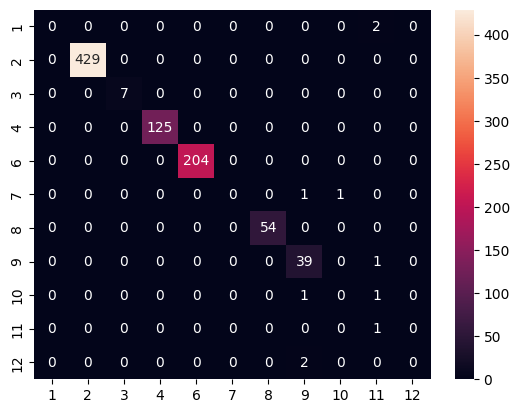

In [100]:
test_label=pd.read_csv('./url/ip/test_label.csv')
right=(test_label['label']==final_predict).sum()
length=len(final_predict)
print(f'{right}/{length}={right/length}')
draw_confusion_matrix(test_label['label'].to_numpy(),final_predict)